In [1]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import numpy as np
from math import sqrt
from shapleycomposition import ShapleyExplainer
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import os

plt.rcParams['axes.grid'] = True
plt.rcParams['savefig.format'] = 'png'

In [2]:
example = '3classes'
out_dir = os.path.join('figures', example, 'gaussians')
os.makedirs(out_dir, exist_ok=True)

## Selecting a qualitative colormap colourblind friendly

Check more details in https://matplotlib.org/stable/users/explain/colors/colormaps.html#colorblindness

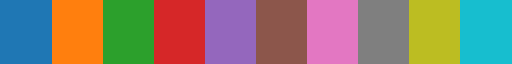

In [3]:
cm = plt.cm.tab10
colors = cm.colors
cm

# Definition of the dataset

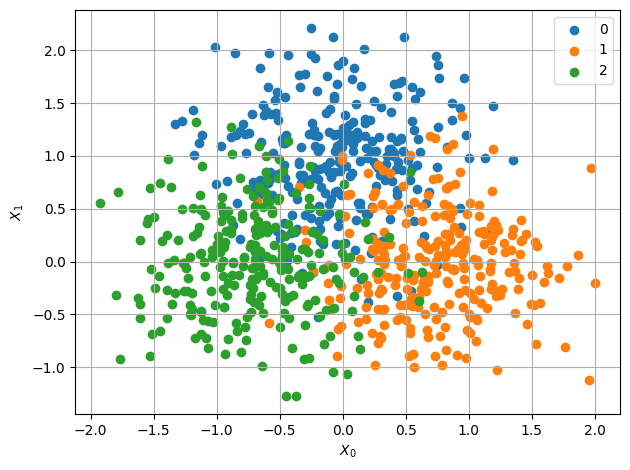

In [4]:
from sklearn.datasets import make_blobs

random_state = 0
n_samples = 1000
n_features = 2

centers = [[0, 1], [np.sqrt(1/2), 0], [-np.sqrt(1/2), 0]]
cluster_std = [.5]*3

n_classes = len(centers)

X, Y = make_blobs(n_samples=n_samples, n_features=n_features,
                          centers=centers, cluster_std=cluster_std,
                          shuffle=True,
                          random_state=random_state)

# Split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

for y in range(n_classes):
    class_indices = Y_train == y
    plt.scatter(X_train[class_indices,0], X_train[class_indices,1], color=colors[y], label=y)
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.legend()

xlim = plt.xlim()
ylim = plt.ylim()

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "dataset_training"), dpi=300, bbox_inches='tight')
plt.show()

## Selection of points of interest

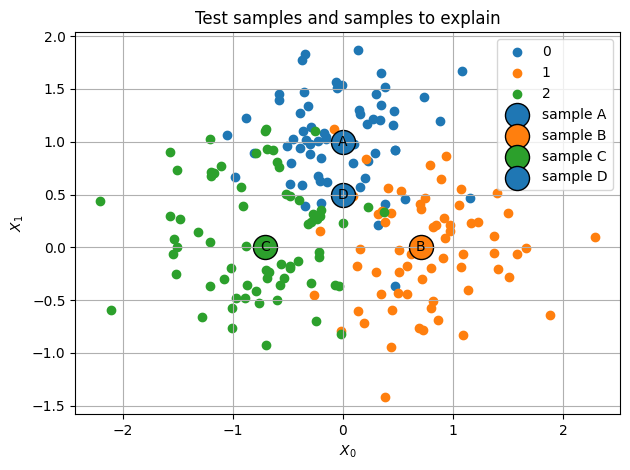

In [5]:
samples_of_interest = {'A': {'X': np.array(centers[0]), 'Y': 0},
                       'B': {'X': np.array(centers[1]), 'Y': 1},
                       'C': {'X': np.array(centers[2]), 'Y': 2},
                       'D': {'X': np.array([0, 1/2]), 'Y': 0}}

for y in range(n_classes):
    class_indices = Y_test == y
    plt.scatter(X_test[class_indices,0], X_test[class_indices,1], label=y)

for sample_id, sample in samples_of_interest.items():
    plt.scatter(sample['X'][0], sample['X'][1], color=colors[sample['Y']],
                s=300, marker='o', edgecolors='k',label=f"sample {sample_id}")
    plt.text(sample['X'][0], sample['X'][1], sample_id, 
             horizontalalignment='center', verticalalignment='center')
    
plt.xlabel('$X_0$')
plt.ylabel('$X_1$')
plt.title('Test samples and samples to explain')

plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "dataset_test_and_samples_explain"), dpi=300, bbox_inches='tight')
plt.show()

# Regions of the feature space to be evaluated

For each sample of interest, shapley will perform all the possible combinations of that sample with the rest of the training samples. The following figure shows all the possible combinations of features for each of those samples of interest.

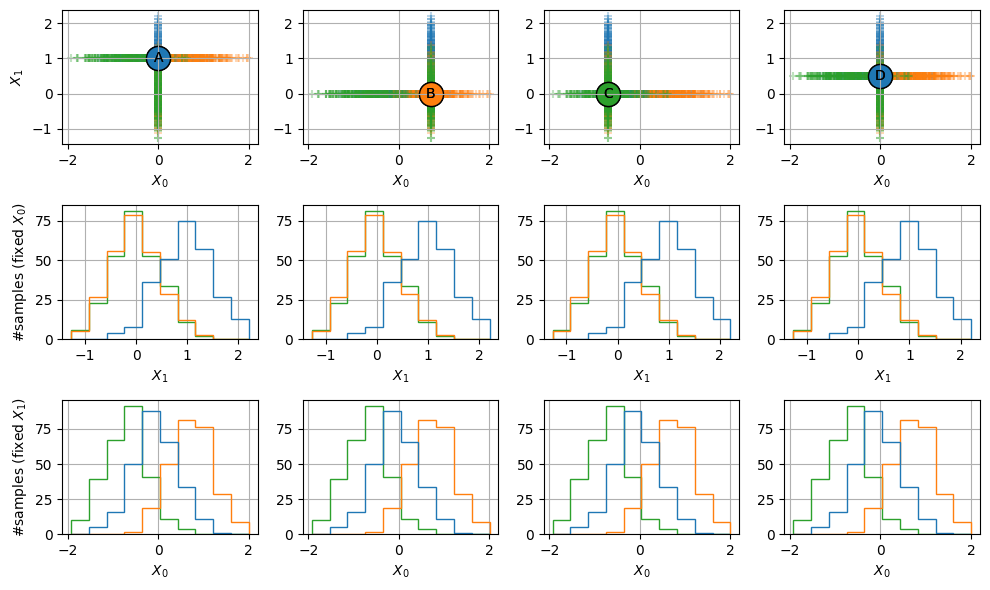

In [6]:
fig = plt.figure(figsize=(10, 2+2*X.shape[1]))
for i, (sample_id, sample) in enumerate(samples_of_interest.items()):
    for feature_id in range(X.shape[1]):
        X_aux = X_train.copy()
        X_aux[:,feature_id] = sample['X'][feature_id]
    
        ax1 = plt.subplot(X.shape[1]+1, len(samples_of_interest), i+1)
        for y in range(n_classes):
            class_indices = Y_train == y
            ax1.scatter(X_aux[class_indices,0], X_aux[class_indices,1],
                        marker='+', label=y, alpha=0.3, color=colors[y])
    
        ax1.scatter(sample['X'][0], sample['X'][1], color=colors[sample['Y']],
                    s=300, marker='o', edgecolors='k',label=f"sample {sample_id}")
        ax1.text(sample['X'][0], sample['X'][1], sample_id, 
                 horizontalalignment='center', verticalalignment='center')
    
        ax1.set_xlim(xlim)
        ax1.set_ylim(ylim)
        ax1.set_xlabel('$X_0$')
    
    
        ax2 = plt.subplot(X.shape[1]+1, len(samples_of_interest), i+1+len(samples_of_interest)*(1+feature_id))
        ax2.hist([X_aux[Y_train == y,1-feature_id] for y in range(n_classes)], 
                 histtype='step', stacked=False, fill=False, color=colors[:n_classes])
        ax2.set_xlabel(f"$X_{1-feature_id}$")
    
        if i == 0:
            ax1.set_ylabel('$X_1$')
            ax2.set_ylabel(f"#samples (fixed $X_{feature_id}$)")

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "samples_of_interst_shapley"), dpi=300, bbox_inches='tight')
plt.show()

# Training a model

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

clf = LogisticRegression()
clf = RandomForestClassifier()
clf = svm.SVC(kernel='rbf', probability=True)
clf.fit(X_train, Y_train)

SVC(probability=True)

## Decision boundaries

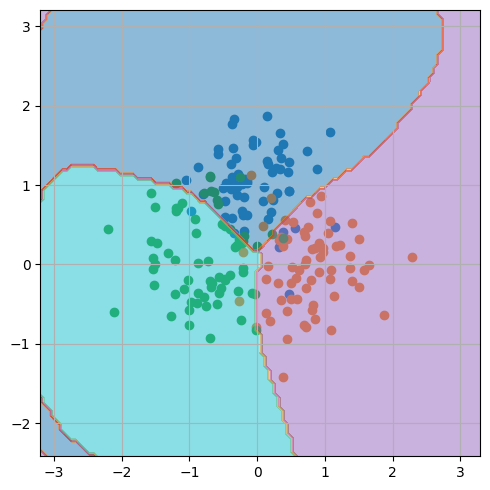

In [8]:
from sklearn.inspection import DecisionBoundaryDisplay

fig = plt.figure(figsize=(5, 5))
for y in range(n_classes):
    class_indices = Y_test == y
    plt.scatter(X_test[class_indices,0], X_test[class_indices,1], label=y)
DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.5, response_method='predict', ax=plt.gca(), cmap=cm)

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "model_decision_boundary"), dpi=300, bbox_inches='tight')
plt.show()

## Predicted posterior probabilities per class

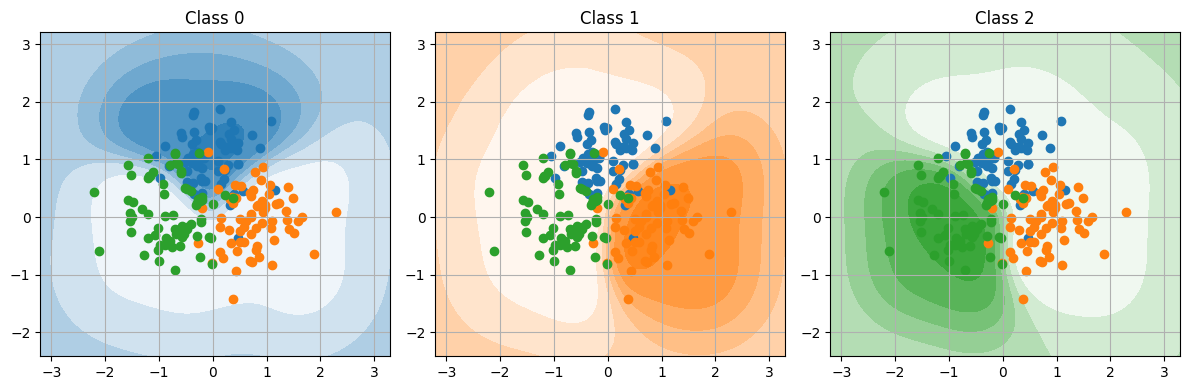

In [9]:
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(figsize=(12, 4))
for i in range(n_classes):
    ax = plt.subplot(1, n_classes, i+1)
    ax.set_title(f"Class {i}")
    DecisionBoundaryDisplay.from_estimator(clf, X, ax=ax, 
                                           cmap=LinearSegmentedColormap.from_list('mycmap', ['white', colors[i]]),
                                           class_of_interest=i, response_method='predict_proba')
    for y in range(n_classes):
        class_indices = Y_test == y
        plt.scatter(X_test[class_indices,0], X_test[class_indices,1], label=y)
plt.tight_layout()
plt.savefig(os.path.join(out_dir, "model_posterior_probabilities"), dpi=300, bbox_inches='tight')
plt.show()

## Model outputs per samples of interest

For each sample of interest we can inspect the outputs of the model for each combination of features.

Prediction on the simplex f(X_A) = [[0.92 0.05 0.03]]
Prediction on the ILR space = [2.08 1.56]
Expected f(X) = [0.60921528 0.20614902 0.1846357 ]
Expected ILR = [0.76620141 0.53235641]

Prediction on the simplex f(X_B) = [[0.04 0.94 0.02]]
Prediction on the ILR space = [-2.26  1.99]
Expected f(X) = [0.16945974 0.5800956  0.25044466]
Expected ILR = [-0.87014972  0.18343916]

Prediction on the simplex f(X_C) = [[0.04 0.01 0.95]]
Prediction on the ILR space = [ 1.2 -3.2]
Expected f(X) = [0.18729592 0.23201984 0.58068424]
Expected ILR = [-0.15141492 -0.83646054]

Prediction on the simplex f(X_D) = [[0.75 0.14 0.11]]
Prediction on the ILR space = [1.2  0.89]
Expected f(X) = [0.41400734 0.2985103  0.28748237]
Expected ILR = [0.23127997 0.16426485]



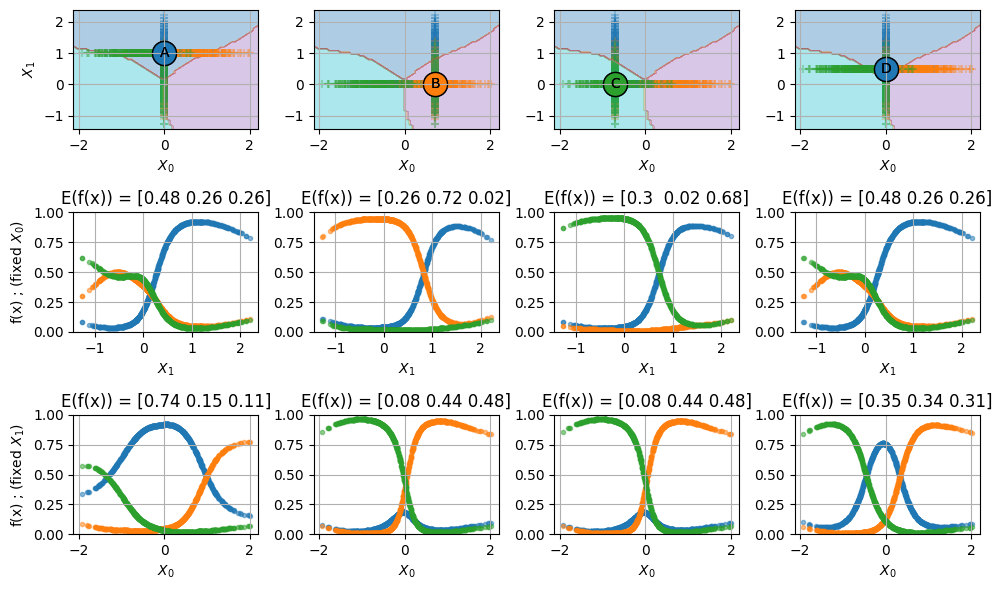

In [10]:
#choose an Aitchison orthonormal basis by setting a sequential binary partition matrix.
#If None, the basis obtained with the gram-schmidt procedure is used
sbpmatrix=np.array([[1,-1,0],[1,1,-1]])
basis = sbp_basis(sbpmatrix)

fig = plt.figure(figsize=(10, 2+2*X.shape[1]))
for i, (sample_id, sample) in enumerate(samples_of_interest.items()):
    expected_fx = []
    for feature_id in range(X.shape[1]):
        X_aux = X_train.copy()
        X_aux[:,feature_id] = sample['X'][feature_id]
    
        ax1 = plt.subplot(X.shape[1]+1, len(samples_of_interest), i+1)
        DecisionBoundaryDisplay.from_estimator(clf, X, alpha=0.2, response_method='predict', ax=ax1, cmap=cm)
        
        for y in range(n_classes):
            class_indices = Y_train == y
            ax1.scatter(X_aux[class_indices,0], X_aux[class_indices,1],
                        marker='+', label=y, alpha=0.3, color=colors[y])
    
        ax1.scatter(sample['X'][0], sample['X'][1], color=colors[sample['Y']],
                    s=300, marker='o', edgecolors='k',label=f"sample {sample_id}")
        ax1.text(sample['X'][0], sample['X'][1], sample_id, 
                 horizontalalignment='center', verticalalignment='center')
    
        ax1.set_xlim(xlim)
        ax1.set_ylim(ylim)
        ax1.set_xlabel('$X_0$')
    
        # Obtain the probability predictions from the model
        predicted_probas = clf.predict_proba(X_aux)
        
        ax2 = plt.subplot(X.shape[1]+1, len(samples_of_interest), i+1+len(samples_of_interest)*(1+feature_id))
        expected_fx.append(predicted_probas.mean(axis=0))
        ax2.set_title(f"E(f(x)) = {expected_fx[-1].round(2)}")
        for y in range(n_classes):
            ax2.scatter(X_aux[:,1-feature_id], predicted_probas[:,y],
                        marker='.', alpha=0.5)
            ax2.set_xlabel(f"$X_{1-feature_id}$")
        ax2.set_ylim([0, 1])
    
        if i == 0:
            ax1.set_ylabel('$X_1$')
            ax2.set_ylabel(f"f(x) ; (fixed $X_{feature_id}$)")
    pred = clf.predict_proba(sample['X'].reshape(1,-1))
    print(f"Prediction on the simplex f(X_{sample_id}) = {pred.round(2)}")
    ilr_pred = ilr(pred, basis=basis)
    print(f"Prediction on the ILR space = {ilr_pred.round(2)}")
    expected = np.vstack(expected_fx).mean(axis=0)
    print(f"Expected f(X) = {expected}")
    ilr_expected = ilr(expected, basis=basis)
    print(f"Expected ILR = {ilr_expected}")
    print()

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "samples_of_interest_shapley_outputs"), dpi=300, bbox_inches='tight')
plt.show()

In [11]:
#sbpmatrix = np.array([[1,-1,0,0],[0,0,1,-1],[1,1,-1,-1]])
#basis = sbp_basis(sbpmatrix)
#root = create_tree_from_sbp(sbpmatrix, n_classes)

##Visualise the tree using graphviz
#graph = init_graph()
#build_graph(root, graph)
#graph       #plot the bifurcation tree

In [12]:
#choose an Aitchison orthonormal basis by setting a sequential binary partition matrix.
#If None, the basis obtained with the gram-schmidt procedure is used
sbpmatrix=np.array([[1,-1,0],[1,1,-1]])
basis = sbp_basis(sbpmatrix)

# Explain all the predictions in the test set
explainer = ShapleyExplainer(clf.predict_proba, X_train, n_classes,
                             names_classes=[f'{i}' for i in range(n_classes)], 
                             names_features=['X_0', 'X_1'])

for sample_id, sample in samples_of_interest.items():
    print(f'Sample of interest {sample_id} = {sample}')
    (shapley, base) = explainer.explain_instance(sample['X'])
    #(shapley, base) = explainer.explain_instance(np.array(sample_to_test))
    
    print("True label of the tested instance: ", end="")
    print(sample['Y'])
    
    #get the model prediction for the Kth instance of the test partition
    pred = clf.predict_proba(sample['X'].reshape(1,-1))
    print("Prediction on the simplex: ",end="")
    print(pred)
    ilr_pred = ilr(pred, basis=basis)
    print("Prediction in the ILR space: ",end="")
    print(ilr_pred)
    
    #The sum of the base distribution and the shapley composition in the ILR space is equal to the predicted probability distribution
    sum_shap_base = np.array(shapley).sum(axis=0)+base
    print("Sum of the shapley composition and the base distribution in the ILR space: ", end="")
    print(sum_shap_base)
    print()

[[ 1. -1.  0.]
 [ 1.  1. -1.]]
Sample of interest A = {'X': array([0, 1]), 'Y': 0}
True label of the tested instance: 0
Prediction on the simplex: [[0.91995543 0.0485744  0.03147017]]
Prediction in the ILR space: [2.07976269 1.55515728]
Sum of the shapley composition and the base distribution in the ILR space: [2.07976289 1.5551574 ]

Sample of interest B = {'X': array([0.70710678, 0.        ]), 'Y': 1}
True label of the tested instance: 1
Prediction on the simplex: [[0.03844517 0.94486362 0.01669121]]
Prediction in the ILR space: [-2.26401981  1.98837694]
Sum of the shapley composition and the base distribution in the ILR space: [-2.26401979  1.98837693]

Sample of interest C = {'X': array([-0.70710678,  0.        ]), 'Y': 2}
True label of the tested instance: 2
Prediction on the simplex: [[0.04399012 0.00805198 0.9479579 ]]
Prediction in the ILR space: [ 1.20070062 -3.20015101]
Sum of the shapley composition and the base distribution in the ILR space: [ 1.20070065 -3.20015102]

Sampl

In [13]:
#SUMMARIZE WITH NORM, COSINE AND INNER PRODUCTS
for sample_id, sample in samples_of_interest.items():
    print(f'Sample of interest {sample_id} = {sample}')
    (shapley, base) = explainer.explain_instance(sample['X'])
    (norm_shapley, proj_shap_class, cos_shap_shap) = explainer.summarize()
    print()

Sample of interest A = {'X': array([0, 1]), 'Y': 0}
List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 X_1: 2.3765682
	 X_0: 0.0439368

Projection of the Shapley compositions on the class vectors:
		X_0       	X_1       	
0:        	-0.0239947	2.3535863	
1:        	0.0438725	-0.8912567	
2:        	-0.0198778	-1.4623296	

Cosine between each Shapley compositions:
		X_0       	X_1       	
X_0:      	1.0000000	-0.4246198	
X_1:      	-0.4246198	1.0000000	

Sample of interest B = {'X': array([0.70710678, 0.        ]), 'Y': 1}
List of the features sorted by their Shapley strength (norm of their Shapley composition):
	 X_0: 2.7791178
	 X_1: 1.0515389

Projection of the Shapley compositions on the class vectors:
		X_0       	X_1       	
0:        	-0.1734319	-1.0421930	
1:        	2.4888115	0.6422403	
2:        	-2.3153796	0.3999527	

Cosine between each Shapley compositions:
		X_0       	X_1       	
X_0:      	1.0000000	0.1946201	
X_1:      	0.1946201

Sample of interest A = {'X': array([0, 1]), 'Y': 0}


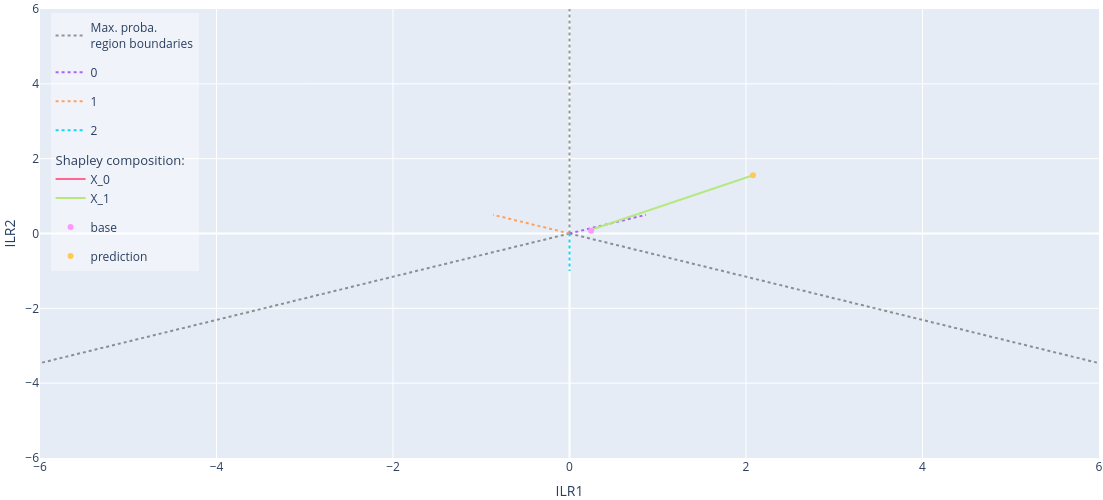

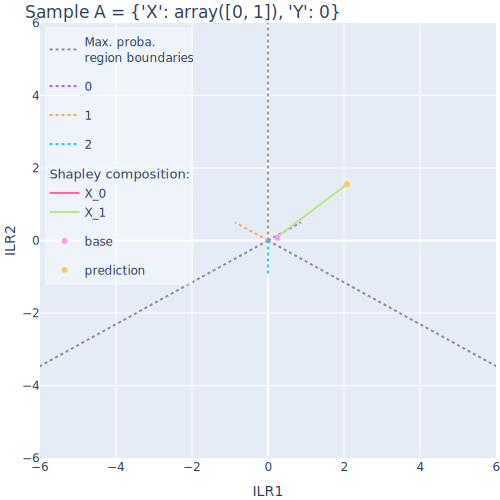

Sample of interest B = {'X': array([0.70710678, 0.        ]), 'Y': 1}


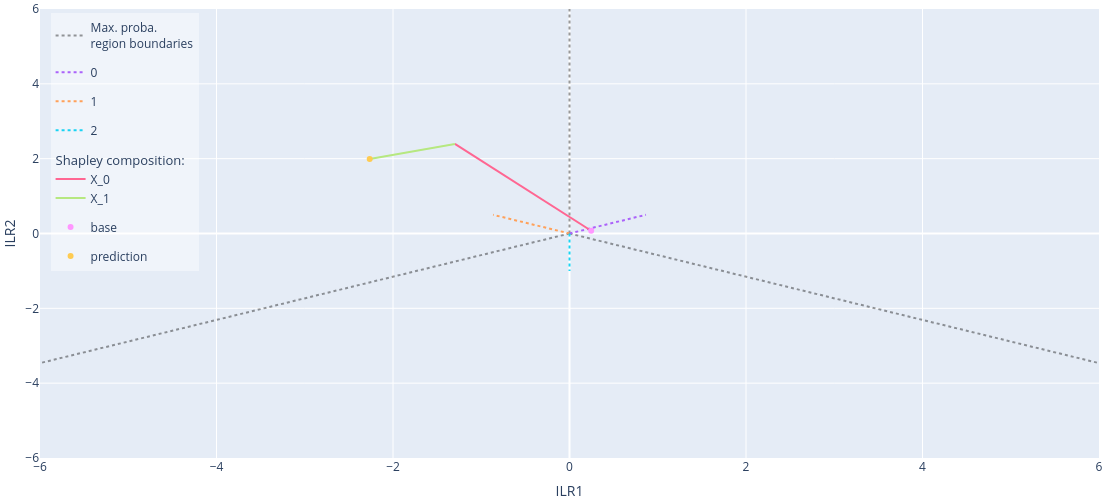

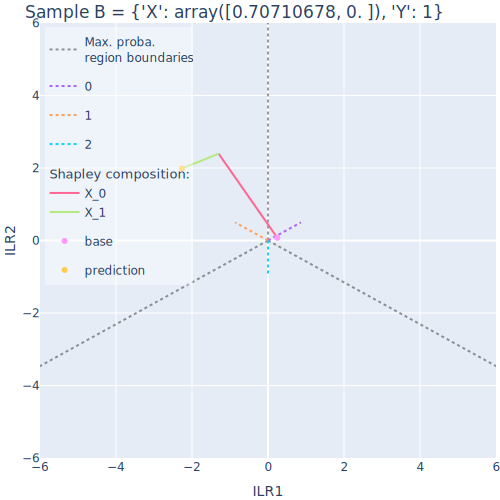

Sample of interest C = {'X': array([-0.70710678,  0.        ]), 'Y': 2}


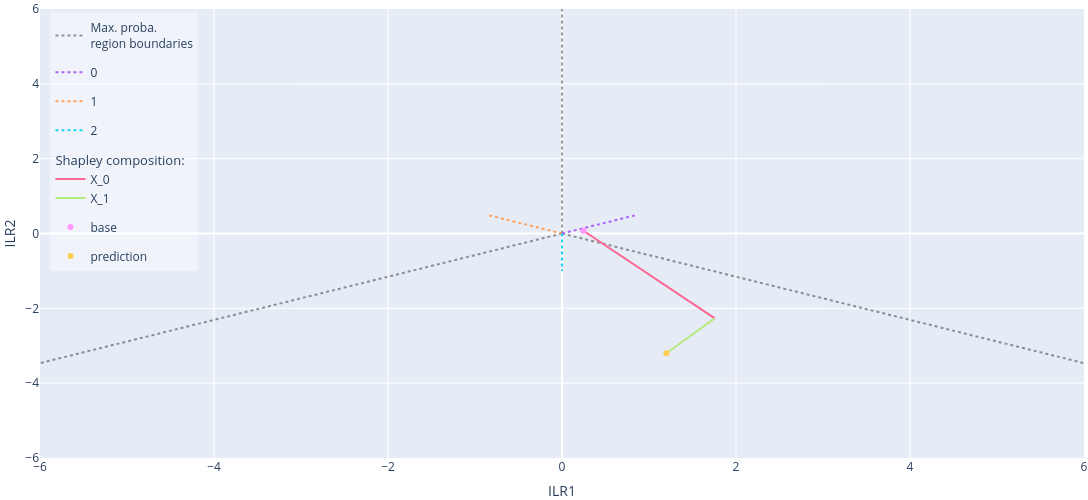

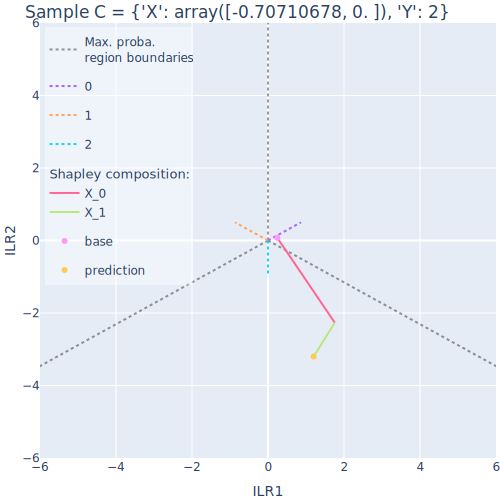

Sample of interest D = {'X': array([0. , 0.5]), 'Y': 0}


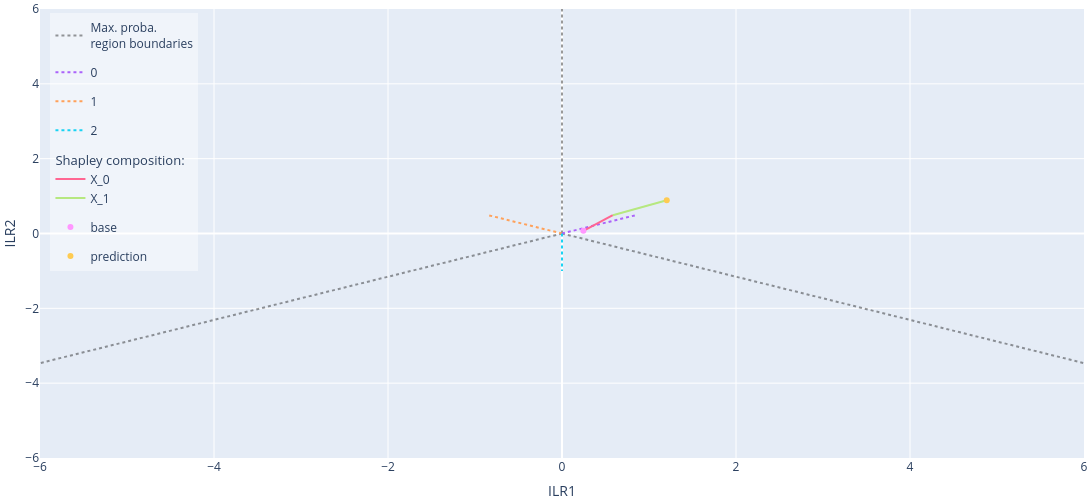

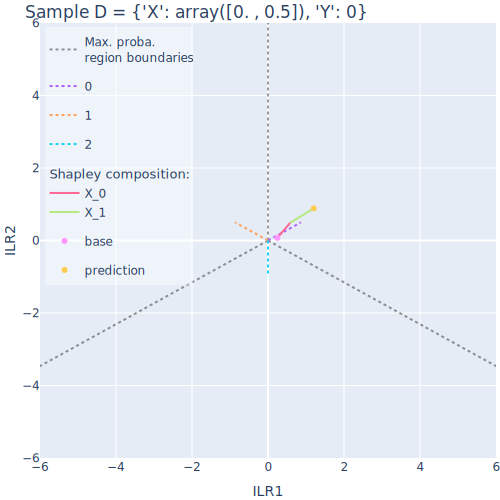

In [14]:
#PLOT the 3D ILR SPACE (CORRESPONDING TO THE CHOSEN ILR COMPONENTS LISTED IN BALANCES).
#plot range [-lim, lim]

#If shapley_sum is True, the sum of the shapley vectors are summed from the base distribution to the prediction

for sample_id, sample in samples_of_interest.items():
    print(f'Sample of interest {sample_id} = {sample}')
    (shapley, base) = explainer.explain_instance(sample['X'])
    ## Removed the composition without base and prediction
    #fig = explainer.plot_ilr_space(balances=[i for i in range(1, n_classes)], lim=6, figsize=500)
    #fig.update_layout(title=dict(text=f"Sample {sample_id} = {sample}"))
    #fig.write_image(os.path.join(out_dir, f"ex_eq4_{sample_id}_ilrplot.pdf"))
    
    fig = explainer.plot_ilr_space(balances=[i for i in range(1, n_classes)], shapley_sum=True, lim=6, figsize=500)
    fig.update_layout(title=dict(text=f"Sample {sample_id} = {sample}", automargin=True, yref='paper'))
    fig.write_image(os.path.join(out_dir, f"ex_eq4_{sample_id}_ilrplotsum.png"))
    fig.show("svg")

Sample of interest A = {'X': array([0, 1]), 'Y': 0}


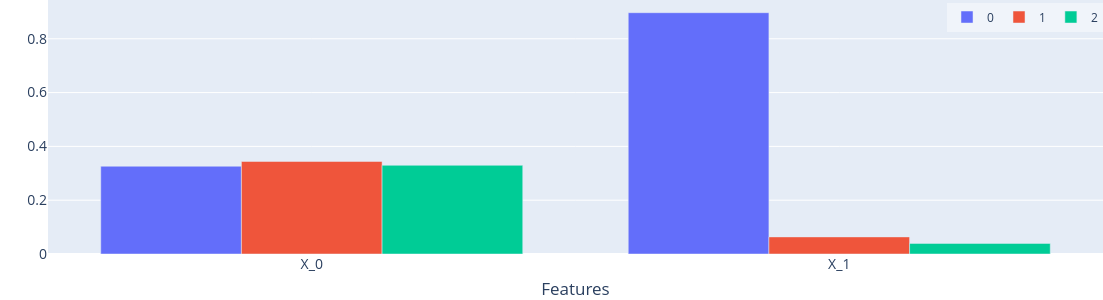

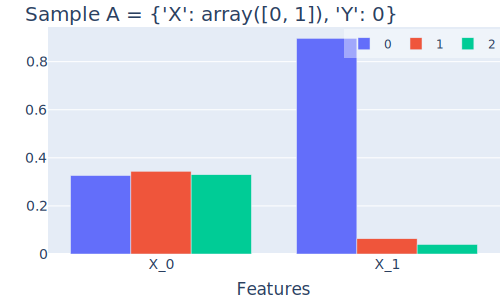

Sample of interest B = {'X': array([0.70710678, 0.        ]), 'Y': 1}


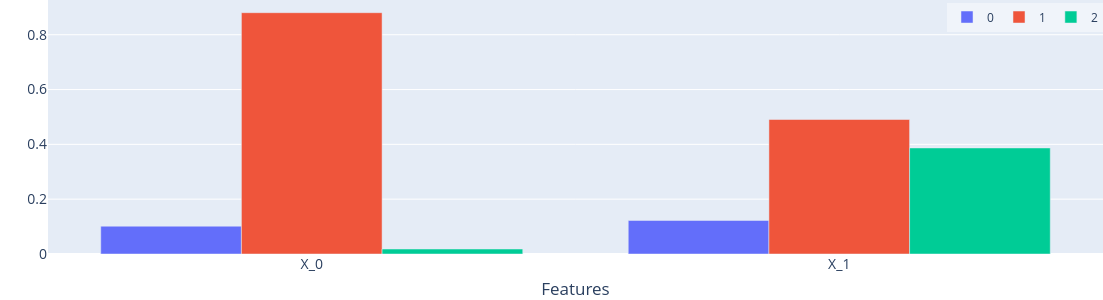

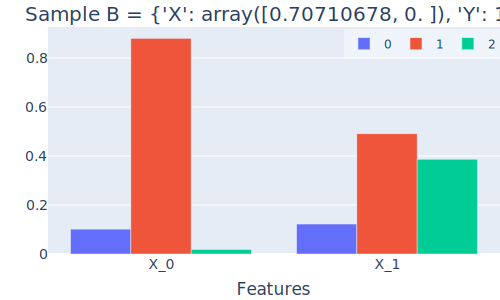

Sample of interest C = {'X': array([-0.70710678,  0.        ]), 'Y': 2}


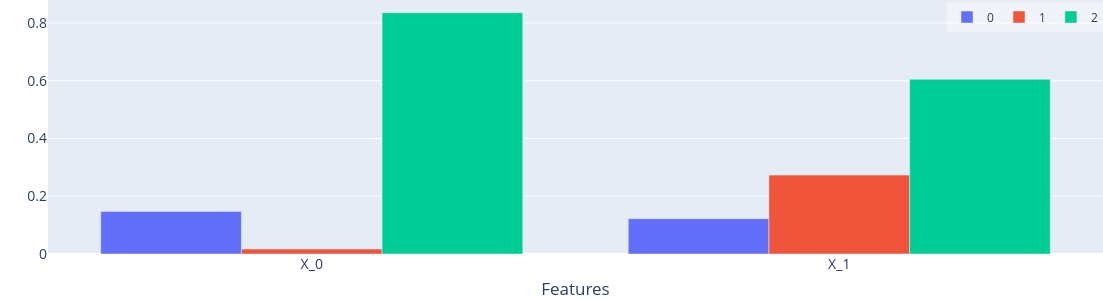

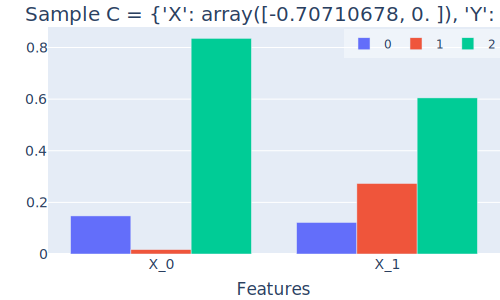

Sample of interest D = {'X': array([0. , 0.5]), 'Y': 0}


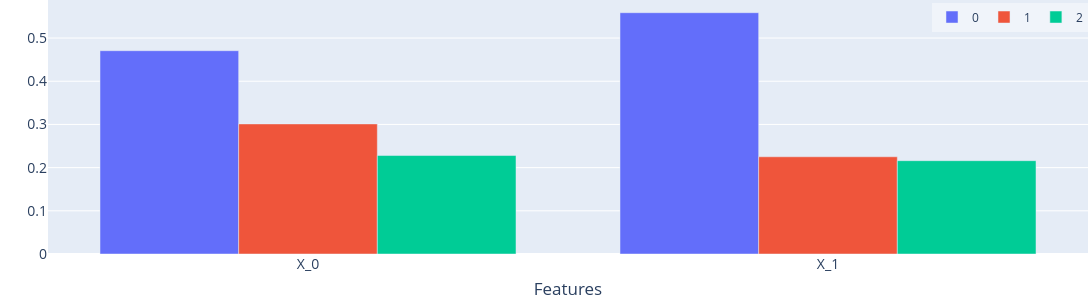

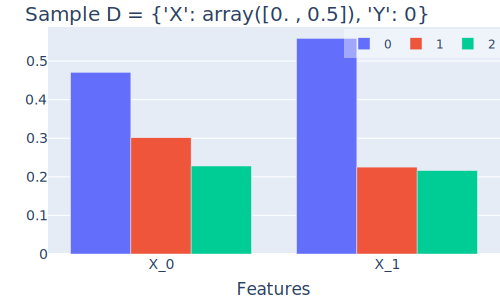

In [15]:
#Plot the Shapley compositions as histograms

for sample_id, sample in samples_of_interest.items():
    print(f'Sample of interest {sample_id} = {sample}')
    (shapley, base) = explainer.explain_instance(sample['X'])
    fig = explainer.shapley_histogram(figheight=300)
    fig.update_layout(title=dict(text=f"Sample {sample_id} = {sample}", automargin=True, yref='paper'))
    fig.write_image(os.path.join(out_dir, f"ex_eq4_{sample_id}_histo.png"))
    fig.show("svg")

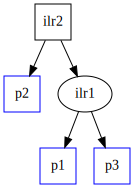

In [16]:
from sklearn.cluster import AgglomerativeClustering
from composition_stats import ilr, sbp_basis
from bifurc_tree import create_tree_from_sbp, init_graph, build_graph, sbp_from_aggloclustchildren
import plotly.graph_objects as go
from mahalanobis_matrix import mahalanobis_matrix
import matplotlib.pyplot as plt

M = mahalanobis_matrix(clf.predict_proba, X_test, Y_test)
sbpmatrix = sbp_from_aggloclustchildren(AgglomerativeClustering(metric='precomputed', linkage='average').fit(M).children_)

#basis = np.flip(sbp_basis(sbpmatrix), axis=0)
basis = sbp_basis(sbpmatrix)
root = create_tree_from_sbp(sbpmatrix, n_classes)

##Visualise the tree using graphviz
graph = init_graph()
build_graph(root, graph)
#graph.render('tree.pdf', view=True)
graph       #plot the bifurcation tree

# Comparison with SHAP

The SHAP library requires that the samples to be tested are inside the explained set.

In [17]:
#X_augmented_test = np.vstack((X_test, np.array([sample['X'] for sample in samples_of_interest.values()])))

In [18]:
#shap_values[0][-len(samples_of_interest):]

In [19]:
X_interest = np.array([sample['X'] for sample in samples_of_interest.values()])

In [20]:
import shap
shap.initjs()

explainer = shap.SamplingExplainer(clf.predict_proba, X_train,
                            output_names=[i for i in range(n_classes)])

shap_values = explainer.shap_values(X_interest)

  0%|          | 0/4 [00:00<?, ?it/s]

Sample of interest A = {'X': array([0, 1]), 'Y': 0}


<Figure size 640x480 with 0 Axes>

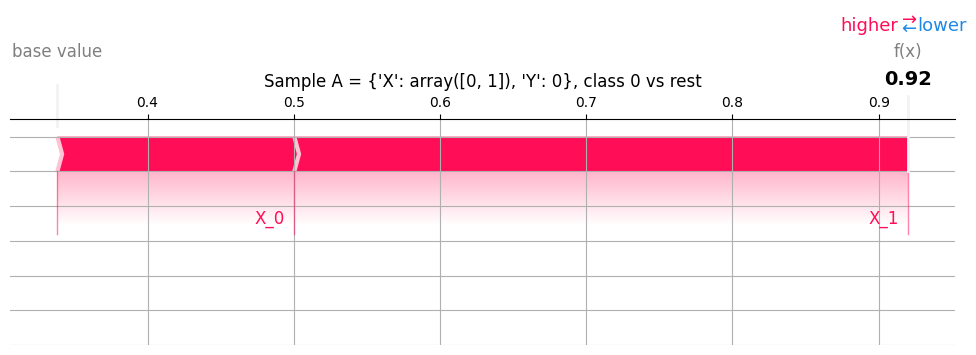

<Figure size 640x480 with 0 Axes>

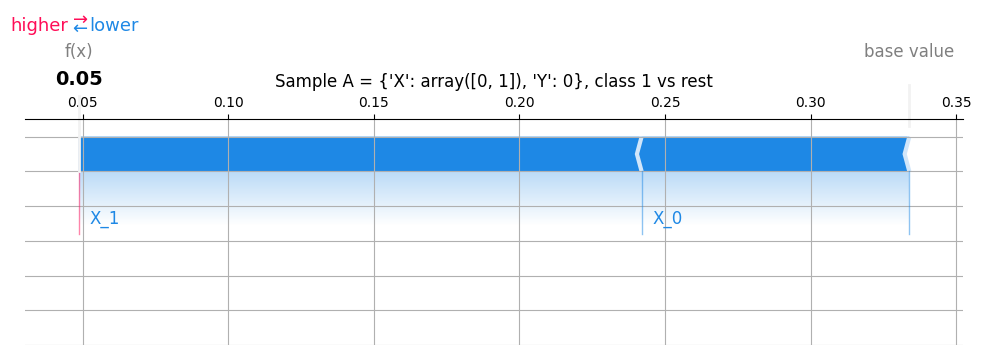

<Figure size 640x480 with 0 Axes>

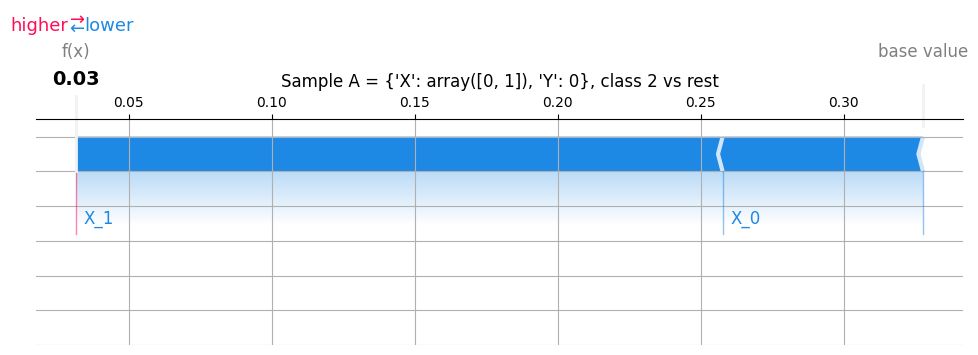

Sample of interest B = {'X': array([0.70710678, 0.        ]), 'Y': 1}


<Figure size 640x480 with 0 Axes>

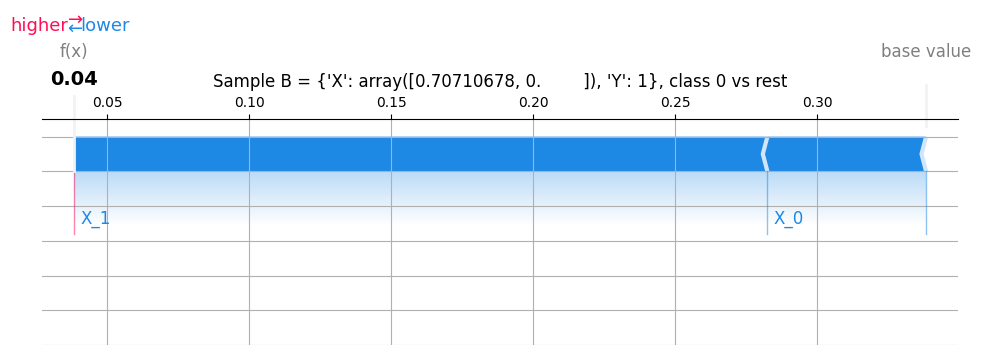

<Figure size 640x480 with 0 Axes>

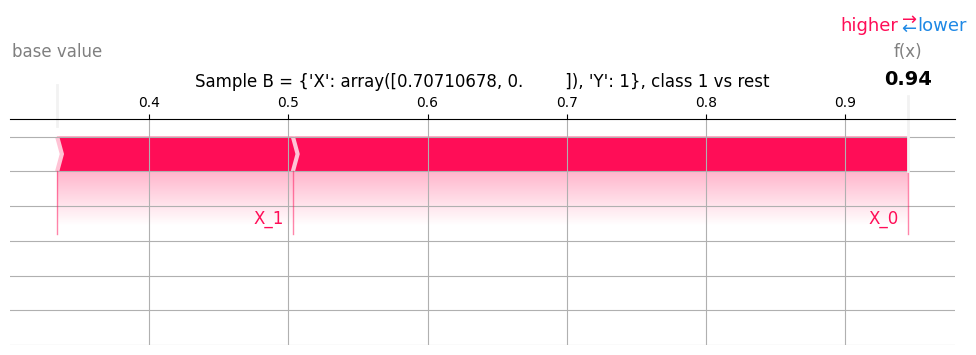

divide by zero encountered in scalar divide


<Figure size 640x480 with 0 Axes>

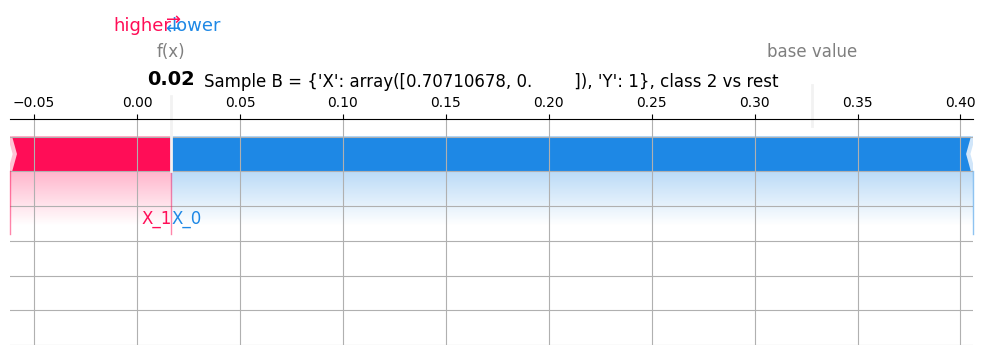

Sample of interest C = {'X': array([-0.70710678,  0.        ]), 'Y': 2}


<Figure size 640x480 with 0 Axes>

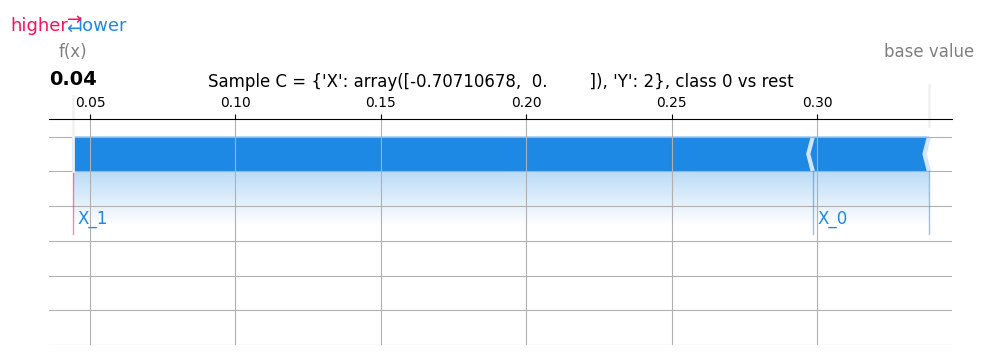

<Figure size 640x480 with 0 Axes>

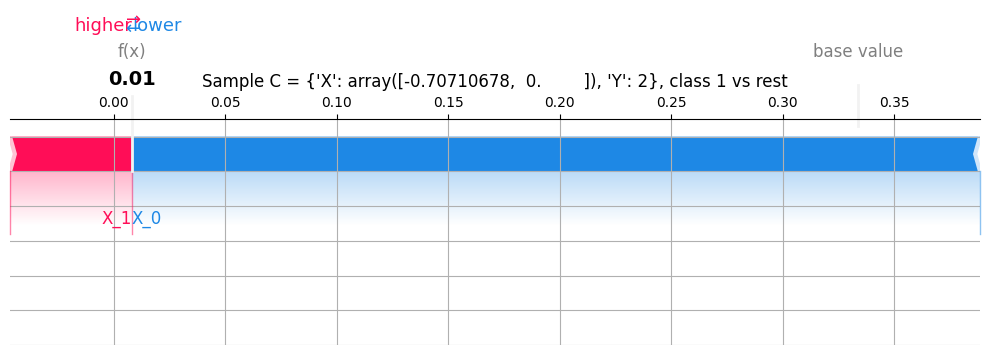

<Figure size 640x480 with 0 Axes>

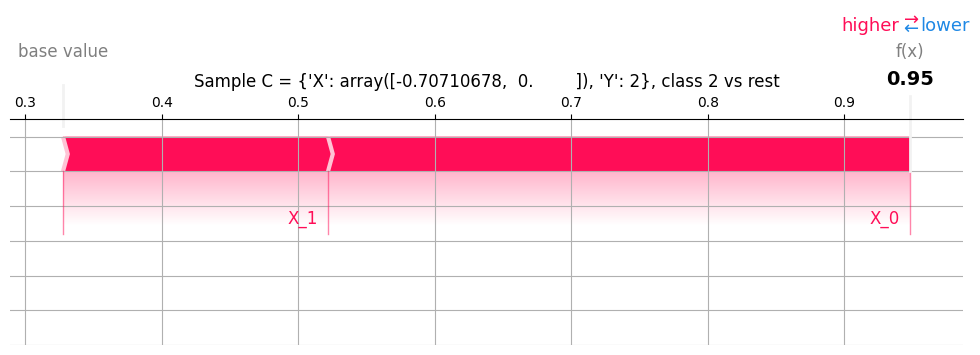

Sample of interest D = {'X': array([0. , 0.5]), 'Y': 0}


<Figure size 640x480 with 0 Axes>

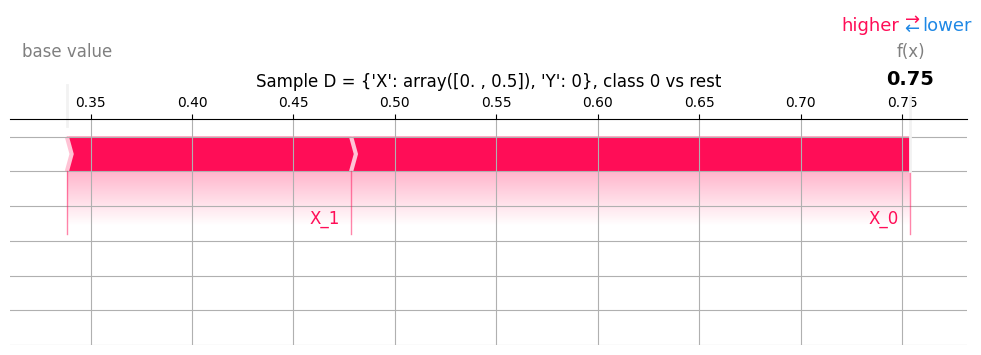

<Figure size 640x480 with 0 Axes>

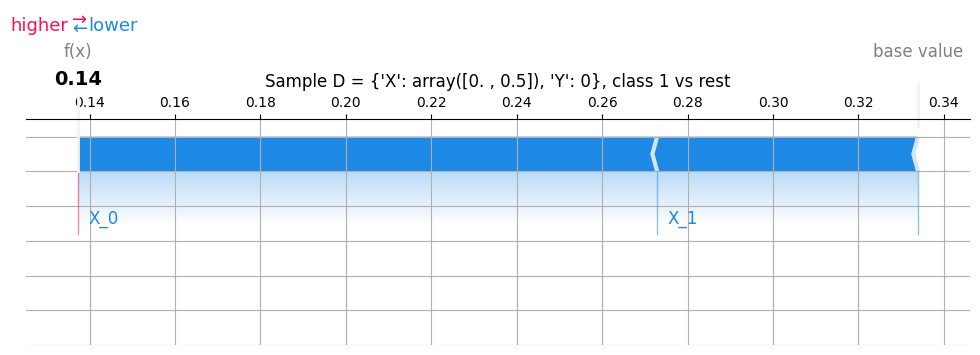

<Figure size 640x480 with 0 Axes>

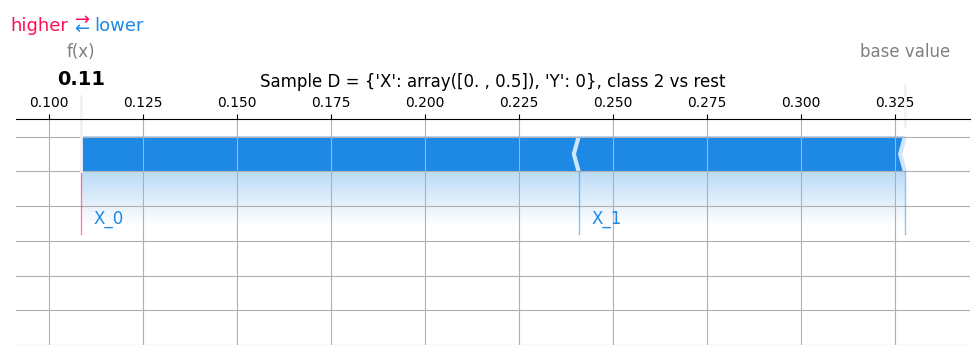

In [21]:

for i, (sample_id, sample) in enumerate(samples_of_interest.items()):
    print(f'Sample of interest {sample_id} = {sample}')
    for label_id in range(n_classes):
        plt.clf()
        shap.force_plot(
            base_value=explainer.expected_value[label_id],
            shap_values=shap_values[label_id][i],
            features=['X_0', 'X_1'],
            matplotlib=True, show=False,
            figsize=(10, 4)
        )
        plt.title(f"Sample {sample_id} = {sample}, class {label_id} vs rest")
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"ex_eq3_{sample_id}_shap_{label_id}"), dpi=300, bbox_inches='tight')
        plt.show()

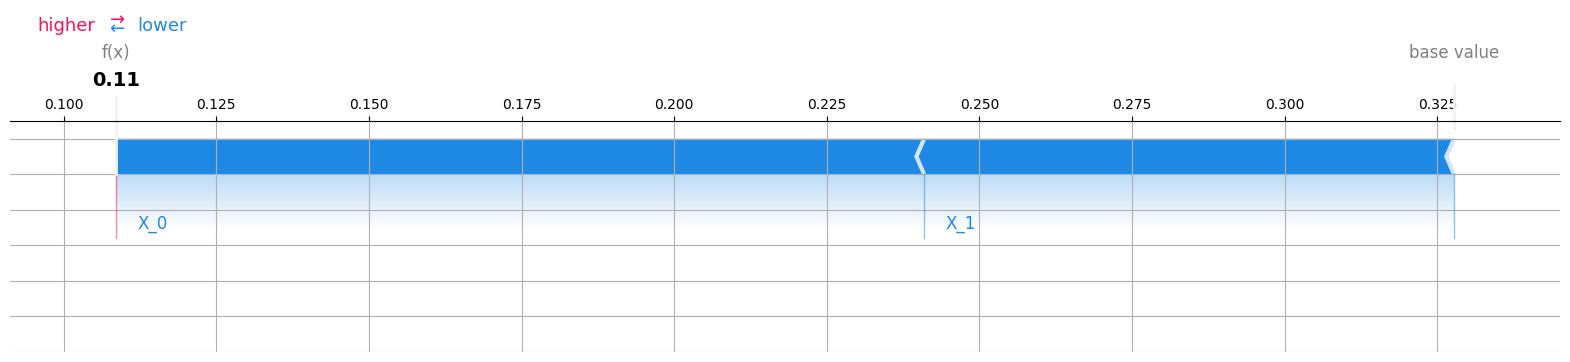

In [22]:
shap.force_plot(
            base_value=explainer.expected_value[label_id],
            shap_values=shap_values[label_id][i],
            features=['X_0', 'X_1'],
            matplotlib=True, show=False,
        )